***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Neural Networks using keras </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Random Forest Classifier </h3></a>
        </ul>
        <ul>
            <a href='#1.C' style="text-decoration : none; color : #000000;"><h3>C. Extra Tree Classifier  </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Neural Networks using keras </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Random Forest Classifier </h3></a>
        </ul>
        <ul>
            <a href='#2.C' style="text-decoration : none; color : #000000;"><h3>C. Extra Tree Classifier  </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Neural Networks using keras </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Random Forest Classifier </h3></a>
        </ul>
        <ul>
            <a href='#3.C' style="text-decoration : none; color : #000000;"><h3>C. Extra Tree Classifier  </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance

def feat_impt_plot(feat_impt,width_s=1000,height_s=1000):
    data = [go.Bar(x=feat_impt.values,y=feat_impt.index.values,text=np.round(feat_impt,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    return cm
 

### The dataset contains http elements present on the specified domain
### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [3]:
df_alex=pd.read_csv('Javascript_alexa_output_final_http.csv',low_memory=False)
df_virus=pd.read_csv('Javascript_malicious_output_final_http.csv',low_memory=False)
df_alex['Malicious']=0
df_virus['Malicious']=1

df=pd.concat([df_alex,df_virus])
             
df = df.sample(frac=1,random_state=867).reset_index(drop=True)
df.fillna(value=0,inplace=True)
df=df[df['html_status']=='Success']
cookie=[col for col in df.columns if 'number' in col]

df.drop(cookie,axis=1,inplace=True)

### Dropping columns that indicate the html status of domain data collection

df.drop(['html_status','html_status_strerror','html_status_message','Unnamed: 0'],axis=1,inplace=True)
df.set_index(['domain'],inplace=True)
df.drop(df.index[29606],inplace=True)

df.Malicious=df.Malicious.apply(lambda x: 'Malicious' if x==1 else 'Non_Malicious')

print("Shape of our dataset:",df.shape)

# df.to_csv('Javascript_dom.csv')

df.head()

Shape of our dataset: (43294, 401)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

#### Let us analyze the balance of classes

In [4]:
data = [go.Bar(x=df.Malicious.value_counts().index.values,
               y=df.Malicious.value_counts().values,
               text=df.Malicious.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [5]:
col_no_unique=[]
for col in df.columns[1:]:
    if len(df[col].value_counts())==1:
        print(col)
        col_no_unique.append(col)

dom_function_document.caretPositionFromPoint(
dom_function_document.caretRangeFromPoint(
dom_function_document.clear(
dom_function_document.createAttributeNS(
dom_function_document.createCDATASection(
dom_function_document.createEntityReference(
dom_function_document.createTouch(
dom_function_document.createTouchList(
dom_function_document.enableStyleSheetsForSet(
dom_function_document.exitPointerLock(
dom_function_document.getAnimations(
dom_function_document.getElementByName(
dom_function_document.getElementsByTagNameNS(
dom_function_document.normalizeDocument(
dom_function_document.queryCommandIndeterm(
dom_function_document.queryCommandValue(
dom_function_document.releaseCapture(
dom_function_document.releaseEvent(
dom_function_document.routeEvent(
dom_function_window.back(
dom_function_window.cancelIdleCallback(
dom_function_window.createImageBitmap(
dom_function_window.disableExternalCapture(
dom_function_window.dump(
dom_function_window.enableExternalCapture(
dom_function_window

In [6]:
print("{} columns have only one unique value in them rendering them less meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

112 columns have only one unique value in them rendering them less meaningless for classification
Shape of our dataset after dropping them: (43294, 289)


In [7]:
### Check and converting data types
df['Malicious']=df.Malicious.apply(lambda x: 1 if x=='Malicious' else 0)

print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: Series([], dtype: object)


#### All of our features are either numerical  in nature.

#### Check for missing data

In [1]:
df.isnull().sum())

NameError: name 'df' is not defined

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [9]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst
col_values.head(5)

,Value_Counts,95_%_same_values
Feature,,
dom_function_document.adoptNode(,{0.0: 43294},True
dom_function_document.captureEvents(,"{0.0: 43258, 1.0: 36}",True
dom_function_document.close(,"{0.0: 42914, 1.0: 273, 2.0: 65, 3.0: 14, 4.0: ...",True
dom_function_document.createAttribute(,"{0.0: 43246, 1.0: 38, 3.0: 5, 2.0: 3, 4.0: 2}",True
dom_function_document.createComment(,"{0.0: 43183, 1.0: 103, 2.0: 7, 3.0: 1}",True


In [10]:
col_values['95_%_same_values'].value_counts()

True     235
False     53
Name: 95_%_same_values, dtype: int64

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [11]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [12]:
cat_var=[]
num_var=[]
for col in columns:
    if len(df[col].value_counts())==2:
        cat_var.append(col)
    else:
        num_var.append(col)

#### No categorical variables. All the variables are continuous variables

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

#### We can also conduct a ttest to see if the two means are different

In [13]:
lst=[]
for col in columns:
    corr=stats.pointbiserialr(df[col],df.Malicious)[0]
    corr_p=stats.pointbiserialr(df[col],df.Malicious)[1]
    ttest=stats.ttest_ind(df[df.Malicious==1][col], df[df.Malicious==0][col], equal_var=False)[0]
    ttest_p=stats.ttest_ind(df[df.Malicious==1][col], df[df.Malicious==0][col], equal_var=False)[1]
    lst.append((corr,corr_p,ttest,ttest_p,col))

stats_df=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
stats_df.set_index('Feature',drop=True,inplace=True)
stats_df.sort_values(by='ttest',inplace=True)
del lst
stats_df

,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00
js_function_.setTime(,-0.083818,2.410642e-68,-41.813198,0.000000e+00
js_function_.replace(,-0.087844,6.536777e-75,-38.924200,0.000000e+00
js_function_.indexOf(,-0.075600,6.618535e-56,-36.469099,9.453374e-287


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [14]:
### Preparing our training and test sets

X=df[columns].values
y=df.Malicious.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [15]:
## Table to store training and test measures so we can compare later
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

#### <a id='1.A' style="text-decoration : none; color : #000000;"> A.  Neural Networks using keras</a>

In [16]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.857918290753


Predicted  False  True  __all__
Actual                         
False      29577    30    29607
True        4891   137     5028
__all__    34468   167    34635

The accuracy of the model on test data is: 0.858182238134


Predicted  False  True  __all__
Actual                         
False       7393     8     7401
True        1220    38     1258
__all__     8613    46     8659

In [17]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.858207016031


Predicted  False  True  __all__
Actual                         
False      29579    28    29607
True        4883   145     5028
__all__    34462   173    34635

The accuracy of the model on test data is: 0.858066751357


Predicted  False  True  __all__
Actual                         
False       7394     7     7401
True        1222    36     1258
__all__     8616    43     8659

#### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Random Forest Classifier</a>

In [18]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.863663923777


Predicted  False  True  __all__
Actual                         
False      29552    55    29607
True        4667   361     5028
__all__    34219   416    34635

The accuracy of the model on test data is: 0.859914539785


Predicted  False  True  __all__
Actual                         
False       7377    24     7401
True        1189    69     1258
__all__     8566    93     8659

In [19]:
f_r=pd.DataFrame(rf.feature_importances_,index=columns)
f_r.columns=['Feature Importance']
f_r.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_r

,Feature Importance
js_function_.push(,0.358933
dom_function_document.createElement(,0.117254
dom_function_document.getElementById(,0.053980
js_function_.getTime(,0.053217
js_function_.replace(,0.046494
dom_function_document.getElementsByTagName(,0.044430
js_function_.indexOf(,0.042650
dom_function_document.write(,0.039051
js_function_.test(,0.024706
dom_function_window.open(,0.021710


#### <a id='1.C' style="text-decoration : none; color : #000000;"> C. Extra Tree Classifier</a>

In [20]:
ext_tree=ExtraTreesClassifier(random_state=0)
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.86427024686


Predicted  False  True  __all__
Actual                         
False      29564    43    29607
True        4658   370     5028
__all__    34222   413    34635

The accuracy of the model on test data is: 0.859914539785


Predicted  False  True  __all__
Actual                         
False       7380    21     7401
True        1192    66     1258
__all__     8572    87     8659

In [21]:
f_e=pd.DataFrame(ext_tree.feature_importances_,index=columns)
f_e.columns=['Feature Importance']
f_e.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_e

,Feature Importance
js_function_.push(,0.234825
dom_function_document.createElement(,0.075383
js_function_.getTime(,0.072136
dom_function_document.getElementsByTagName(,0.071557
js_function_.replace(,0.067253
dom_function_document.getElementById(,0.038119
js_function_.apply(,0.037714
dom_function_document.write(,0.029555
js_function_.test(,0.022277
js_function_.find(,0.019373


In [22]:
avg_feat_impt=(pd.concat((f_r,f_e), axis=1).mean(axis=1).sort_values(ascending=False))

feat_impt_plot(avg_feat_impt[0:20])

In [23]:
indx=['Neural_Network','RandomForestClassifier','ExtraTreeClassifier']

table_80_50_test['index']=indx
table_80_50_train['index']=indx

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Set")
display(table_80_50_train)
print("\nTest Set")
display(table_80_50_test)

Training Set


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural_Network,0.858207,145.0,29579.0,28.0,4883.0,0.000946,0.971161
RandomForestClassifier,0.863664,361.0,29552.0,55.0,4667.0,0.001858,0.928202
ExtraTreeClassifier,0.864270,370.0,29564.0,43.0,4658.0,0.001452,0.926412



Test Set


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural_Network,0.858067,36.0,7394.0,7.0,1222.0,0.000946,0.971383,0.513836
RandomForestClassifier,0.859915,69.0,7377.0,24.0,1189.0,0.003243,0.945151,0.525803
ExtraTreeClassifier,0.859915,66.0,7380.0,21.0,1192.0,0.002837,0.947536,0.524813


In [24]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Neural_Network')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'RandomForestClassifier')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

data = [trace0, trace1, trace2]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

#### The results are good. The models seem to be perfoming well and have a good FPR and FNR. Next we will perform feature tranformations to see how we can improve results

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [25]:
df.reset_index(inplace=True)

columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [26]:
df_min.domain=df_min.domain.astype('str')

In [27]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 5565 features
EntitySet scattered to workers in 6.860 seconds
Elapsed: 00:52 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [28]:
feature_matrix_sessions.head()

,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substr,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_Object.defineProperty(,js_function_Object.keys(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,js_function_unescape(,js_function_.replace( + js_function_.slice(,js_function_.pop( + js_function_unescape(,js_function_.push( + js_function_.shift(,dom_function_window.setTimeout( + js_function_.push(,js_function_.forEach( + js_function_isNaN(,js_function_.replace( + js_function_Math.max(,js_function_.test( + js_function_parseInt(,js_function_.join( + js_function_.replace(,js_function_.push( + js_function_.slice(,js_function_.pop( + js_function_Math.round(,dom_function_document.createElement( + dom_function_window.setTimeout(,js_function_.getTime( + js_function_Math.random(,js_function_.shift( + js_function_Math.max(,js_function_.defineProperty( + js_function_unescape(,js_function_.apply( + js_function_Object.defineProperty(,dom_function_document.createElement( + js_function_Math.random(,js_function_.add( + js_function_parseInt(,js_function_.match( + js_function_.setTime(,js_function_.indexOf( + js_function_Object.keys(,js_function_.shift( + js_function_escape(,js_function_.forEach( + js_function_.log(,js_function_.add( + js_function_.defineProperty(,js_function_.concat( + js_function_encodeURIComponent(,js_function_.keys( + js_function_.pop(,js_function_.keys( + js_function_unescape(,js_function_.add( + js_function_.apply(,js_function_.log( + js_function_.trim(,js_function_decodeURIComponent( + js_function_JSON.stringify(,js_function_.indexOf( + js_function_Math.floor(,js_function_encodeURIComponent( + js_function_isNaN(,dom_function_window.addEventListener( + dom_function_window.open(,js_function_.match( + js_function_.substr,dom_function_document.getElementsByTagName( + js_function_decodeURIComponent(,js_function_.toString( + js_function_decodeURIComponent(,js_function_.concat( + js_function_.getTime(,js_function_.match( + js_function_escape(,js_function_.get( + js_function_.hasOwnProperty(,dom_function_window.addEventListener( + js_function_.match(,js_function_.pop( + js_function_.test(,js_function_.bind( + js_function_.concat(,js_function_.setTime( + js_function_Object.keys(,js_function_.setTime( + js_function_isNaN(,dom_function_document.getElementsByTagName( + dom_function_window.addEventListener(,js_function_.get( + js_function_escape(,js_function_.call( + js_function_.pop(,js_function_.trim( + js_function_decodeURIComponent(,js_function_.match( + js_function_JSON.parse(,dom_function_window.addEventListener( + js_function_.apply(,js_function_.hasOwnProperty( + js_function_.indexOf(,dom_function_document.querySelector( + js_function_.forEach(,js_function_.apply( + js_function_.replace(,dom_function_document.getElementById( + js_function_.concat(,js_function_.exec( + js_function_.push(,js_function_.add( + js_function_.indexOf(,js_function_.split( + js_function_escape(,dom_function_win

In [29]:
df.set_index(['domain'],drop=True,inplace=True)

fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Malicious),left_index=True, right_index=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [30]:
X=fs.loc[:,df.columns!='Malicious']
y=fs.Malicious
feature_name = X.columns.tolist()

In [31]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()


rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=10, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()


embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [32]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
y=fs.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43293, 61)

In [33]:
feature_name

['dom_function_document.getElementById( + dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement( + js_function_Math.random(',
 'js_function_decodeURIComponent( + js_function_Math.round(',
 'js_function_decodeURIComponent( + js_function_Math.random(',
 'js_function_Math.random(',
 'js_function_Math.floor(',
 'js_function_.substring( + js_function_encodeURIComponent(',
 'js_function_.substr + js_function_.test(',
 'js_function_.split( + js_function_parseInt(',
 'js_function_.split( + js_function_escape(',
 'js_function_.split( + js_function_decodeURIComponent(',
 'js_function_.split(',
 'js_function_.setTime( + js_function_Math.floor(',
 'js_function_.setTime(',
 'js_function_.replace( + js_function_Math.max(',
 'js_function_.replace( + js_function_.substring(',
 'js_function_.replace( + js_function_.split(',
 'js_function_.replace( + js_function_.slice(',
 'js_function_.replace(',
 'js_function_.match( + js_function_Math.random(',
 'js_function_.match( + js

In [34]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

#### <a id='2.A' style="text-decoration : none; color : #000000;"> A.  Neural Networks using keras</a>

In [35]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_60_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_60_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.856181786677


Predicted  False  True  __all__
Actual                         
False      29613     6    29619
True        4975    40     5015
__all__    34588    46    34634

The accuracy of the model on test data is: 0.855064095161


Predicted  False  True  __all__
Actual                         
False       7387     2     7389
True        1253    17     1270
__all__     8640    19     8659

#### <a id='2.B' style="text-decoration : none; color : #000000;"> B.  Random Forest Classifier</a>

In [36]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_60_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_60_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.862302939308


Predicted  False  True  __all__
Actual                         
False      29548    71    29619
True        4698   317     5015
__all__    34246   388    34634

The accuracy of the model on test data is: 0.858644185241


Predicted  False  True  __all__
Actual                         
False       7361    28     7389
True        1196    74     1270
__all__     8557   102     8659

In [37]:
f_r=pd.DataFrame(rf.feature_importances_,index=feature_name)
f_r.columns=['Feature Importance']
f_r.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_r

,Feature Importance
dom_function_document.createElement( + js_function_.substring(,0.082004
dom_function_document.createElement( + js_function_.defineProperty(,0.076279
js_function_.apply( + js_function_.replace(,0.053681
dom_function_document.getElementById( + js_function_.test(,0.051231
dom_function_document.createElement( + dom_function_window.setTimeout(,0.044316
js_function_.replace( + js_function_.split(,0.042718
dom_function_document.createElement( + js_function_.setTime(,0.040817
dom_function_document.createElement(,0.036342
dom_function_document.getElementsByTagName( + dom_function_window.addEventListener(,0.035498
dom_function_document.createElement( + js_function_Math.random(,0.033511


#### <a id='2.C' style="text-decoration : none; color : #000000;"> C.  Extra Tree Classifier</a>

In [38]:
ext_tree=ExtraTreesClassifier()
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_60_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_60_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.862880406537


Predicted  False  True  __all__
Actual                         
False      29567    52    29619
True        4697   318     5015
__all__    34264   370    34634

The accuracy of the model on test data is: 0.859452592678


Predicted  False  True  __all__
Actual                         
False       7374    15     7389
True        1202    68     1270
__all__     8576    83     8659

In [39]:
f_e=pd.DataFrame(ext_tree.feature_importances_,index=feature_name)
f_e.columns=['Feature Importance']
f_e.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_e

,Feature Importance
dom_function_document.createElement( + js_function_Math.floor(,0.053325
dom_function_document.createElement( + js_function_.defineProperty(,0.049745
js_function_.getTime(,0.049259
dom_function_document.getElementsByTagName( + dom_function_window.addEventListener(,0.044075
js_function_.replace(,0.043516
dom_function_document.getElementById( + js_function_.test(,0.039897
js_function_.getTime( + js_function_.replace(,0.038424
js_function_.split( + js_function_escape(,0.035250
dom_function_document.getElementById( + dom_function_document.getElementsByTagName(,0.034957
js_function_.substring( + js_function_encodeURIComponent(,0.032064


In [40]:
avg_feat_impt=(pd.concat((f_r,f_e), axis=1).mean(axis=1).sort_values(ascending=False))
feat_impt_plot(avg_feat_impt[0:20])

In [41]:
table_80_60_test['index']=indx
table_80_60_train['index']=indx

table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Set")
display(table_80_60_train)
print("\nTest Set")
display(table_80_60_test)

Training Set


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural_Network,0.856182,40.0,29613.0,6.0,4975.0,0.000203,0.992024
RandomForestClassifier,0.862303,317.0,29548.0,71.0,4698.0,0.002397,0.936790
ExtraTreeClassifier,0.862880,318.0,29567.0,52.0,4697.0,0.001756,0.936590



Test Set


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural_Network,0.855064,17.0,7387.0,2.0,1253.0,0.000271,0.986614,0.506558
RandomForestClassifier,0.858644,74.0,7361.0,28.0,1196.0,0.003789,0.941732,0.527239
ExtraTreeClassifier,0.859453,68.0,7374.0,15.0,1202.0,0.002030,0.946457,0.525757


In [42]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Neural_Network')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'RandomForestClassifier')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

data = [trace0, trace1, trace2]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [43]:
X=fs.loc[:,df.columns!='Malicious']
y=fs.Malicious.values
feature_name = X.columns.tolist()
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

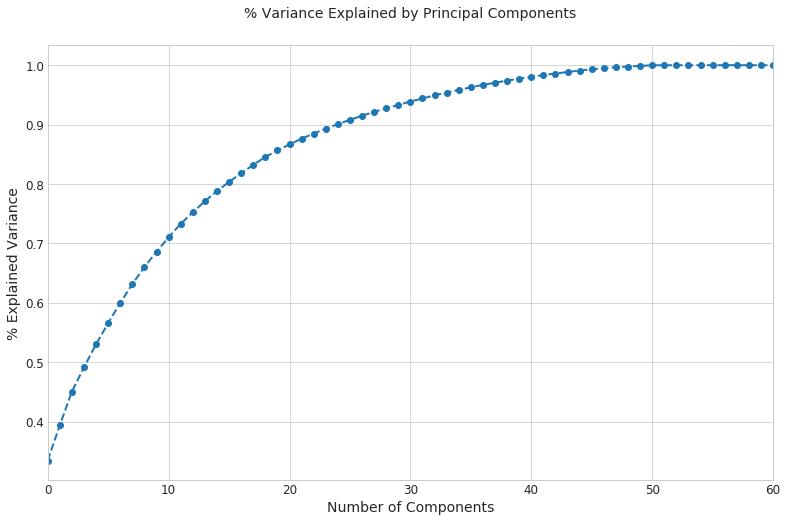

In [44]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(13, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,60])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [45]:
pca=PCA(n_components=50,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 50 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 50 components is: 0.998892809482


In [46]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [47]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

#### <a id='3.A' style="text-decoration : none; color : #000000;"> A.  Neural Networks using keras</a>

In [48]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.860368424085


Predicted  False  True  __all__
Actual                         
False      29573    46    29619
True        4790   225     5015
__all__    34363   271    34634

The accuracy of the model on test data is: 0.859221619125


Predicted  False  True  __all__
Actual                         
False       7379    10     7389
True        1209    61     1270
__all__     8588    71     8659

#### <a id='3.B' style="text-decoration : none; color : #000000;"> B.  Random Forest Classifier</a>

In [49]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.863659987296


Predicted  False  True  __all__
Actual                         
False      29561    58    29619
True        4664   351     5015
__all__    34225   409    34634

The accuracy of the model on test data is: 0.859568079455


Predicted  False  True  __all__
Actual                         
False       7375    14     7389
True        1202    68     1270
__all__     8577    82     8659

#### <a id='3.C' style="text-decoration : none; color : #000000;"> C.  Extra Tree Classifier</a>

In [50]:
ext_tree=ExtraTreesClassifier(random_state=0)
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.864583934862


Predicted  False  True  __all__
Actual                         
False      29568    51    29619
True        4639   376     5015
__all__    34207   427    34634

The accuracy of the model on test data is: 0.859337105901


Predicted  False  True  __all__
Actual                         
False       7371    18     7389
True        1200    70     1270
__all__     8571    88     8659

In [51]:
table_80_70_test['index']=indx
table_80_70_train['index']=indx

table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Set")
display(table_80_70_train)
print("\nTest Set")
display(table_80_70_test)

Training Set


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural_Network,0.860368,225.0,29573.0,46.0,4790.0,0.001553,0.955135
RandomForestClassifier,0.863660,351.0,29561.0,58.0,4664.0,0.001958,0.930010
ExtraTreeClassifier,0.864584,376.0,29568.0,51.0,4639.0,0.001722,0.925025



Test Set


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural_Network,0.859222,61.0,7379.0,10.0,1209.0,0.001353,0.951969,0.523339
RandomForestClassifier,0.859568,68.0,7375.0,14.0,1202.0,0.001895,0.946457,0.525824
ExtraTreeClassifier,0.859337,70.0,7371.0,18.0,1200.0,0.002436,0.944882,0.526341


In [52]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Neural_Network')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'RandomForestClassifier')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

data = [trace0, trace1, trace2]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 3')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

#### Both the Extra Tree Model and Random Forest Classifier perform well.  We can try to improve the results by perfroming Grid Search and hypertuning the parameters

### Lets try the same approaches using oversampling (SMOTE technique) to see if we can improve the results

In [53]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substr',
 'js_function_.substring(',
 'js_function_.test(

In [54]:
### Preparing our training and test sets
X=df[columns].values
y=df.Malicious.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [55]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [56]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_80_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_80_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.889738913095


Predicted  False   True  __all__
Actual                          
False      23904   5703    29607
True         826  28781    29607
__all__    24730  34484    59214

The accuracy of the model on test data is: 0.829887977827


Predicted  False  True  __all__
Actual                         
False       5989  1412     7401
True          61  1197     1258
__all__     6050  2609     8659

In [57]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_80_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_80_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.904954909312


Predicted  False   True  __all__
Actual                          
False      24163   5444    29607
True         184  29423    29607
__all__    24347  34867    59214

The accuracy of the model on test data is: 0.837048157986


Predicted  False  True  __all__
Actual                         
False       6049  1352     7401
True          59  1199     1258
__all__     6108  2551     8659

In [58]:
f_r=pd.DataFrame(rf.feature_importances_,index=columns)
f_r.columns=['Feature Importance']
f_r.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_r

,Feature Importance
js_function_.push(,0.351880
dom_function_document.createElement(,0.138730
js_function_.getTime(,0.064812
dom_function_document.getElementById(,0.063709
js_function_.indexOf(,0.060240
dom_function_document.getElementsByTagName(,0.051981
js_function_.replace(,0.040763
js_function_.test(,0.035338
dom_function_document.write(,0.035023
js_function_.match(,0.014681


In [59]:
ext_tree=ExtraTreesClassifier(random_state=0)
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_80_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_80_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.905292667275


Predicted  False   True  __all__
Actual                          
False      24175   5432    29607
True         176  29431    29607
__all__    24351  34863    59214

The accuracy of the model on test data is: 0.837279131539


Predicted  False  True  __all__
Actual                         
False       6054  1347     7401
True          62  1196     1258
__all__     6116  2543     8659

In [60]:
f_e=pd.DataFrame(ext_tree.feature_importances_,index=columns)
f_e.columns=['Feature Importance']
f_e.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_e

,Feature Importance
js_function_.push(,0.155857
dom_function_document.getElementsByTagName(,0.111137
js_function_.getTime(,0.078792
js_function_.apply(,0.060539
js_function_.replace(,0.055854
dom_function_document.createElement(,0.047382
dom_function_document.getElementById(,0.033273
js_function_.substring(,0.025207
js_function_.test(,0.023682
js_function_.concat(,0.022089


In [61]:
avg_feat_impt=(pd.concat((f_r,f_e), axis=1).mean(axis=1).sort_values(ascending=False))

feat_impt_plot(avg_feat_impt)

In [62]:
table_80_80_test['index']=indx
table_80_80_train['index']=indx

table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Set")
display(table_80_80_train)
print("\nTest Set")
display(table_80_80_test)

Training Set


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural_Network,0.889739,28781.0,23904.0,5703.0,826.0,0.192623,0.027899
RandomForestClassifier,0.904955,29423.0,24163.0,5444.0,184.0,0.183875,0.006215
ExtraTreeClassifier,0.905293,29431.0,24175.0,5432.0,176.0,0.183470,0.005945



Test Set


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural_Network,0.829888,1197.0,5989.0,1412.0,61.0,0.190785,0.048490,0.880363
RandomForestClassifier,0.837048,1199.0,6049.0,1352.0,59.0,0.182678,0.046900,0.885211
ExtraTreeClassifier,0.837279,1196.0,6054.0,1347.0,62.0,0.182002,0.049285,0.884356


In [63]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Neural_Network')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'RandomForestClassifier')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

data = [trace0, trace1, trace2]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 3')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

### Lets now see the results of undersampling. 

In [64]:
df_non=df[df.Malicious==0]
df_mal=df[df.Malicious==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Malicious.value_counts() 

X=df_u[columns]
y=df_u.Malicious.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12572, 289)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.execCommand(,dom_function_document.getElementById(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.dispatchEvent(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.getComputedStyle(,dom_function_window.getSelection(,dom_function_window.matchMedia(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollTo(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setTimeout(,dom_function_window.stop(,js_function_.add(,js_function_.all(,js_function_.anchor(,js_function_.apply(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_function_.call(,js_function_.catch(,js_function_.charAt(,js_function_.charCodeAt(,js_function_.clear(,js_function_.codePointAt(,js_function_.compile(,js_function_.concat(,js_function_.construct(,js_function_.defineProperty(,js_function_.delete(,js_function_.deleteProperty(,js_function_.endWith(,js_function_.entries(,js_function_.every(,js_function_.exec(,js_function_.fill(,js_function_.filter(,js_function_.find(,js_function_.findIndex(,js_function_.flatMap(,js_function_.fontcolor(,js_function_.forEach(,js_function_.from(,js_function_.get(,js_function_.getDate(,js_function_.getDay(,js_function_.getFullYear(,js_function_.getHours(,js_function_.getInt16(,js_function_.getInt32(,js_function_.getInt8(,js_function_.getMilliseconds(,js_function_.getMinutes(,js_function_.getMonth(,js_function_.getOwnPropertyDescriptor(,js_function_.getPrototypeOf(,js_function_.getSeconds(,js_function_.getTime(,js_function_.getTimezoneOffset(,js_function_.getUTCDate(,js_function_.getUTCDay(,js_function_.getUTCFullYear(,js_function_.getUTCHours(,js_function_.getUTCMilliseconds(,js_function_.getUTCMinutes(,js_function_.getUTCMonth(,js_function_.getUTCSeconds(,js_function_.getUint16(,js_function_.getUint32(,js_function_.getUint8(,js_function_.getYear(,js_function_.has(,js_function_.hasOwnProperty(,js_function_.includes(,js_function_.indexOf(,js_function_.isExtensible(,js_function_.isPrototypeOf(,js_function_.italics(,js_function_.join(,js_function_.keys(,js_function_.lastIndexOf(,js_function_.link(,js_function_.localeCompare(,js_function_.log(,js_function_.map(,js_function_.match(,js_function_.min(,js_function_.next(,js_function_.normalize(,js_function_.of(,js_function_.o

In [65]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [66]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [67]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_90_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_90_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.87501242916


Predicted  False  True  __all__
Actual                         
False       3968  1082     5050
True         175  4832     5007
__all__     4143  5914    10057

The accuracy of the model on test data is: 0.868389662028


Predicted  False  True  __all__
Actual                         
False        949   287     1236
True          44  1235     1279
__all__      993  1522     2515

In [68]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_90_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_90_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.903052600179


Predicted  False  True  __all__
Actual                         
False       4150   900     5050
True          75  4932     5007
__all__     4225  5832    10057

The accuracy of the model on test data is: 0.88986083499


Predicted  False  True  __all__
Actual                         
False       1002   234     1236
True          43  1236     1279
__all__     1045  1470     2515

In [69]:
f_r=pd.DataFrame(rf.feature_importances_,index=columns)
f_r.columns=['Feature Importance']
f_r.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_r

,Feature Importance
js_function_.push(,0.355064
dom_function_document.createElement(,0.132433
js_function_.getTime(,0.063148
js_function_.indexOf(,0.057696
dom_function_document.getElementsByTagName(,0.052830
dom_function_document.getElementById(,0.049641
js_function_.replace(,0.036410
js_function_.test(,0.034019
dom_function_document.write(,0.029115
js_function_.match(,0.015148


In [70]:
ext_tree=ExtraTreesClassifier(random_state=0)
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_90_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_90_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.905936163866


Predicted  False  True  __all__
Actual                         
False       4159   891     5050
True          55  4952     5007
__all__     4214  5843    10057

The accuracy of the model on test data is: 0.889463220676


Predicted  False  True  __all__
Actual                         
False        999   237     1236
True          41  1238     1279
__all__     1040  1475     2515

In [71]:
f_e=pd.DataFrame(ext_tree.feature_importances_,index=columns)
f_e.columns=['Feature Importance']
f_e.sort_values(by='Feature Importance',ascending=False,inplace=True)
f_e

,Feature Importance
js_function_.push(,0.220282
dom_function_document.createElement(,0.083820
js_function_.getTime(,0.074425
dom_function_document.getElementsByTagName(,0.072479
js_function_.replace(,0.070380
dom_function_document.getElementById(,0.033274
js_function_.match(,0.029262
js_function_.apply(,0.026480
dom_function_window.addEventListener(,0.025664
js_function_.log(,0.021191


In [72]:
avg_feat_impt=(pd.concat((f_r,f_e), axis=1).mean(axis=1).sort_values(ascending=False))

feat_impt_plot(avg_feat_impt)

In [73]:
table_80_90_test['index']=indx
table_80_90_train['index']=indx

table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Set")
display(table_80_90_train)
print("\nTest Set")
display(table_80_90_test)

Training Set


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural_Network,0.875012,4832.0,3968.0,1082.0,175.0,0.214257,0.034951
RandomForestClassifier,0.903053,4932.0,4150.0,900.0,75.0,0.178218,0.014979
ExtraTreeClassifier,0.905936,4952.0,4159.0,891.0,55.0,0.176436,0.010985



Test Set


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural_Network,0.868390,1235.0,949.0,287.0,44.0,0.232201,0.034402,0.866699
RandomForestClassifier,0.889861,1236.0,1002.0,234.0,43.0,0.189320,0.033620,0.888530
ExtraTreeClassifier,0.889463,1238.0,999.0,237.0,41.0,0.191748,0.032056,0.888098


### Depth 2

In [79]:
from itertools import combinations
df_depth_2=df_min[np.append(stats_df.index.values[0:25],'domain')]

df_depth_2.set_index(['domain'],drop=True,inplace=True)

columns=df_depth_2.columns

In [80]:
# Create all combinations of length 2 . eg. AB, BC, etc
for combination in combinations(columns, 2):
    combination_string = " + ".join(combination)
    df_depth_2[combination_string] = df_depth_2[combination[1]]+df_depth_2[combination[0]]
    combination_string = " * ".join(combination)
    df_depth_2[combination_string] = df_depth_2[combination[1]]*df_depth_2[combination[0]]
    combination_string = " / ".join(combination)
    df_depth_2[combination_string] = df_depth_2[combination[1]]/df_depth_2[combination[0]]

In [81]:
# Create all combinations of length 2 . eg. AB, BC, etc.
for combination in combinations(columns, 3):
    combination_string = " + ".join(combination)
    df_depth_2[combination_string] = df_depth_2[combination[2]]+df_depth_2[combination[1]]+df_depth_2[combination[0]]
    combination_string = " * ".join(combination)
    df_depth_2[combination_string] = df_depth_2[combination[2]]*df_depth_2[combination[1]]*df_depth_2[combination[0]]
    combination_string = " / ".join(combination)
    df_depth_2[combination_string] = (df_depth_2[combination[2]]/df_depth_2[combination[1]])/df_depth_2[combination[0]]

In [82]:
display(df_depth_2.shape)
df_depth_2.head()

(43294, 7825)

,dom_function_document.getElementsByTagName(,dom_function_document.createElement(,js_function_.getTime(,dom_function_window.addEventListener(,js_function_.split(,js_function_Math.random(,js_function_.setTime(,js_function_.replace(,js_function_.indexOf(,js_function_Math.floor(,js_function_decodeURIComponent(,js_function_.match(,js_function_JSON.parse(,js_function_.pop(,js_function_.charAt(,js_function_.concat(,js_function_encodeURIComponent(,js_function_.test(,js_function_.apply(,js_function_.substr,js_function_Math.round(,js_function_.substring(,js_function_.shift(,js_function_.join(,js_function_.push(,dom_function_document.getElementsByTagName( + dom_function_document.createElement(,dom_function_document.getElementsByTagName( * dom_function_document.createElement(,dom_function_document.getElementsByTagName( / dom_function_document.createElement(,dom_function_document.getElementsByTagName( + js_function_.getTime(,dom_function_document.getElementsByTagName( * js_function_.getTime(,dom_function_document.getElementsByTagName( / js_function_.getTime(,dom_function_document.getElementsByTagName( + dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( * dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( / dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( + js_function_.split(,dom_function_document.getElementsByTagName( * js_function_.split(,dom_function_document.getElementsByTagName( / js_function_.split(,dom_function_document.getElementsByTagName( + js_function_Math.random(,dom_function_document.getElementsByTagName( * js_function_Math.random(,dom_function_document.getElementsByTagName( / js_function_Math.random(,dom_function_document.getElementsByTagName( + js_function_.setTime(,dom_function_document.getElementsByTagName( * js_function_.setTime(,dom_function_document.getElementsByTagName( / js_function_.setTime(,dom_function_document.getElementsByTagName( + js_function_.replace(,dom_function_document.getElementsByTagName( * js_function_.replace(,dom_function_document.getElementsByTagName( / js_function_.replace(,dom_function_document.getElementsByTagName( + js_function_.indexOf(,dom_function_document.getElementsByTagName( * js_function_.indexOf(,dom_function_document.getElementsByTagName( / js_function_.indexOf(,dom_function_document.getElementsByTagName( + js_function_Math.floor(,dom_function_document.getElementsByTagName( * js_function_Math.floor(,dom_function_document.getElementsByTagName( / js_function_Math.floor(,dom_function_document.getElementsByTagName( + js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( * js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( / js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( + js_function_.match(,dom_function_document.getElementsByTagName( * js_function_.match(,dom_function_document.getElementsByTagName( / js_function_.match(,dom_function_document.getElementsByTagName( + js_function_JSON.parse(,dom_function_document.getElementsByTagName( * js_function_JSON.parse(,dom_function_document.getElementsByTagName( / js_function_JSON.parse(,dom_function_document.getElementsByTagName( + js_function_.pop(,dom_function_document.getElementsByTagName( * js_function_.pop(,dom_function_document.getElementsByTagName( / js_function_.pop(,dom_function_document.getElementsByTagName( + js_function_.charAt(,dom_function_document.getElementsByTagName( * js_function_.charAt(,dom_function_document.getElementsByTagName( / js_function_.charAt(,dom_function_document.getElementsByTagName( + js_function_.concat(,dom_function_document.getElementsByTagName( * js_function_.concat(,dom_function_document.getElementsByTagName( / js_function_.concat(,dom_function_document.getElementsByTagName( + js_function_encodeURIComponent(,dom_function_document.getElementsByTagName( * js_function_encodeURIComponent(,dom_function_document.getElementsByTagName( / js_function_en

In [83]:
# df.set_index(['domain'],drop=True,inplace=True)

fs=pd.merge(df_depth_2,pd.DataFrame(df.Malicious),left_index=True, right_index=True)

In [84]:
fs.fillna(value=0,inplace=True)
fs.head()

,dom_function_document.getElementsByTagName(,dom_function_document.createElement(,js_function_.getTime(,dom_function_window.addEventListener(,js_function_.split(,js_function_Math.random(,js_function_.setTime(,js_function_.replace(,js_function_.indexOf(,js_function_Math.floor(,js_function_decodeURIComponent(,js_function_.match(,js_function_JSON.parse(,js_function_.pop(,js_function_.charAt(,js_function_.concat(,js_function_encodeURIComponent(,js_function_.test(,js_function_.apply(,js_function_.substr,js_function_Math.round(,js_function_.substring(,js_function_.shift(,js_function_.join(,js_function_.push(,dom_function_document.getElementsByTagName( + dom_function_document.createElement(,dom_function_document.getElementsByTagName( * dom_function_document.createElement(,dom_function_document.getElementsByTagName( / dom_function_document.createElement(,dom_function_document.getElementsByTagName( + js_function_.getTime(,dom_function_document.getElementsByTagName( * js_function_.getTime(,dom_function_document.getElementsByTagName( / js_function_.getTime(,dom_function_document.getElementsByTagName( + dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( * dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( / dom_function_window.addEventListener(,dom_function_document.getElementsByTagName( + js_function_.split(,dom_function_document.getElementsByTagName( * js_function_.split(,dom_function_document.getElementsByTagName( / js_function_.split(,dom_function_document.getElementsByTagName( + js_function_Math.random(,dom_function_document.getElementsByTagName( * js_function_Math.random(,dom_function_document.getElementsByTagName( / js_function_Math.random(,dom_function_document.getElementsByTagName( + js_function_.setTime(,dom_function_document.getElementsByTagName( * js_function_.setTime(,dom_function_document.getElementsByTagName( / js_function_.setTime(,dom_function_document.getElementsByTagName( + js_function_.replace(,dom_function_document.getElementsByTagName( * js_function_.replace(,dom_function_document.getElementsByTagName( / js_function_.replace(,dom_function_document.getElementsByTagName( + js_function_.indexOf(,dom_function_document.getElementsByTagName( * js_function_.indexOf(,dom_function_document.getElementsByTagName( / js_function_.indexOf(,dom_function_document.getElementsByTagName( + js_function_Math.floor(,dom_function_document.getElementsByTagName( * js_function_Math.floor(,dom_function_document.getElementsByTagName( / js_function_Math.floor(,dom_function_document.getElementsByTagName( + js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( * js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( / js_function_decodeURIComponent(,dom_function_document.getElementsByTagName( + js_function_.match(,dom_function_document.getElementsByTagName( * js_function_.match(,dom_function_document.getElementsByTagName( / js_function_.match(,dom_function_document.getElementsByTagName( + js_function_JSON.parse(,dom_function_document.getElementsByTagName( * js_function_JSON.parse(,dom_function_document.getElementsByTagName( / js_function_JSON.parse(,dom_function_document.getElementsByTagName( + js_function_.pop(,dom_function_document.getElementsByTagName( * js_function_.pop(,dom_function_document.getElementsByTagName( / js_function_.pop(,dom_function_document.getElementsByTagName( + js_function_.charAt(,dom_function_document.getElementsByTagName( * js_function_.charAt(,dom_function_document.getElementsByTagName( / js_function_.charAt(,dom_function_document.getElementsByTagName( + js_function_.concat(,dom_function_document.getElementsByTagName( * js_function_.concat(,dom_function_document.getElementsByTagName( / js_function_.concat(,dom_function_document.getElementsByTagName( + js_function_encodeURIComponent(,dom_function_document.getElementsByTagName( * js_function_encodeURIComponent(,dom_function_document.getElementsByTagName( / js_function_en

In [85]:
fs.replace([np.inf],0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [112]:
X=fs.loc[:,fs.columns!='Malicious']
y=fs.Malicious.values
feature_name = X.columns.tolist()
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

In [108]:
pca = PCA(random_state=0)
pca.fit(scaled_X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

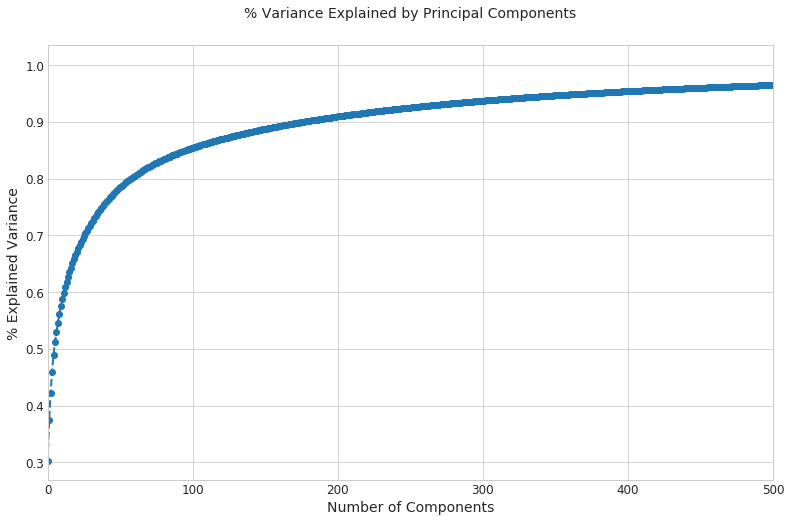

In [109]:
sns.set_style('whitegrid')

plt.figure(1, figsize=(13, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,500])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [110]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)

(array([ 176,  177,  178, ..., 7822, 7823, 7824]),)

In [113]:
pca=PCA(n_components=176,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 96 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 96 components is: 0.899455765303


In [114]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [115]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

#### <a id='3.A' style="text-decoration : none; color : #000000;"> A.  Neural Networks using keras</a>

In [116]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.860166310565


Predicted  False  True  __all__
Actual                         
False      29577    49    29626
True        4794   214     5008
__all__    34371   263    34634

The accuracy of the model on test data is: 0.85829772491


Predicted  False  True  __all__
Actual                         
False       7361    21     7382
True        1206    71     1277
__all__     8567    92     8659

#### <a id='3.B' style="text-decoration : none; color : #000000;"> B.  Random Forest Classifier</a>

In [117]:
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[1]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[1]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.862158572501


Predicted  False  True  __all__
Actual                         
False      29577    49    29626
True        4725   283     5008
__all__    34302   332    34634

The accuracy of the model on test data is: 0.859221619125


Predicted  False  True  __all__
Actual                         
False       7364    18     7382
True        1201    76     1277
__all__     8565    94     8659

#### <a id='3.C' style="text-decoration : none; color : #000000;"> C.  Extra Tree Classifier</a>

In [118]:
ext_tree=ExtraTreesClassifier(random_state=0)
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_70_train.loc[2]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[2]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is:  0.862649419645


Predicted  False  True  __all__
Actual                         
False      29570    56    29626
True        4701   307     5008
__all__    34271   363    34634

The accuracy of the model on test data is: 0.859337105901


Predicted  False  True  __all__
Actual                         
False       7358    24     7382
True        1194    83     1277
__all__     8552   107     8659

In [120]:
## Original Creator : Darshan Bhansali
## HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')